In [501]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dt_apriltags import Detector
import random
from math import dist

image_file = 'pool_lane.png'

In [502]:
def detect_lines(img1, threshold1, threshold2, apertureSize, minLineLength, maxLineGap):
    img = cv2.imread(img1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    edges = cv2.Canny(gray, threshold1, threshold2, apertureSize) # detect edges
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=minLineLength, maxLineGap=maxLineGap) # detect lines
    return lines

line_list = detect_lines(image_file, 30, 50, 3, 150, 200)
print(line_list)
print(len(line_list))


[[[2651 1100 3784 1321]]

 [[2543 1027 3809 1182]]

 [[1065 2026 1436 1409]]

 [[1010 2123 1405 1465]]

 [[1010 2121 1422 1434]]

 [[1017 2112 1406 1465]]

 [[2809 1058 3819 1182]]

 [[2652 1100 3782 1319]]

 [[1427 2106 1617 1343]]

 [[2634 1040 3813 1185]]

 [[1006 2134 1397 1483]]

 [[1423 2130 1606 1396]]

 [[2664 1104 3784 1322]]

 [[1425 2107 1618 1333]]

 [[2810 1058 3813 1181]]

 [[3145 1194 3780 1317]]

 [[1440 2040 1628 1288]]]
17


[2651 1100 3784 1321]
[2543 1027 3809 1182]
[1065 2026 1436 1409]
[1010 2123 1405 1465]
[1010 2121 1422 1434]
[1017 2112 1406 1465]
[2809 1058 3819 1182]
[2652 1100 3782 1319]
[1427 2106 1617 1343]
[2634 1040 3813 1185]
[1006 2134 1397 1483]
[1423 2130 1606 1396]
[2664 1104 3784 1322]
[1425 2107 1618 1333]
[2810 1058 3813 1181]
[3145 1194 3780 1317]
[1440 2040 1628 1288]


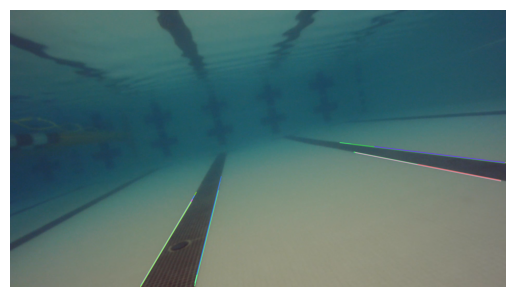

In [503]:
#def draw_lines(img2, lines, color):
def draw_lines(img2, lines):
    img = cv2.imread(img2)
    for line in lines:
        print(line[0])
        x1, y1, x2, y2 = line[0]
        color = (
            random.randint(50, 255),  # Red
            random.randint(50, 255),  # Green
            random.randint(50, 255)   # Blue
        )
        cv2.line(img, (x1, y1), (x2, y2), (color[0], color[1], color[2]), 5)
    return img


# Draw lines and get the result image
#output_img = draw_lines(image_file, line_list, (0, 255, 0))
output_img = draw_lines(image_file, line_list)

# Convert BGR to RGB for displaying with matplotlib
output_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

# Show the image
plt.imshow(output_rgb)
plt.axis('off')
plt.show()

In [504]:
def get_slopes_intercepts(lines):
    slope_list = []
    x_intercept_list = []
    for line in lines: 
        x1, y1, x2, y2 = line[0]
        if x2 - x1 == 0 or (y2 - y1)/(x2 - x1) == 0:
            slope = float('inf')  # vertical line
            x_intercept = x1      # vertical line: x-intercept is x
            slope_list.append(float(slope))
            x_intercept_list.append(float(x_intercept))
        else:
            slope = (y2 - y1)/(x2 - x1)
            x_intercept = x1 - (y1/slope)
            slope_list.append(float(slope))
            x_intercept_list.append(float(x_intercept))
    return slope_list, x_intercept_list

print(get_slopes_intercepts(line_list))

([0.19505736981465135, 0.12243285939968404, -1.6630727762803235, -1.6658227848101266, -1.6674757281553398, -1.6632390745501284, 0.12277227722772277, 0.19380530973451326, -4.015789473684211, 0.12298558100084818, -1.6649616368286444, -4.0109289617486334, 0.19464285714285715, -4.010362694300518, 0.1226321036889332, 0.19370078740157481, -4.0], [-2988.366515837104, -5845.270967741935, 2283.226904376013, 2284.445288753799, 2281.9825327510916, 2286.8114374034003, -5808.58064516129, -3023.799086757991, 1951.429882044561, -5822.275862068966, 2287.711213517665, 1954.049046321526, -3007.9266055045873, 1950.388888888889, -5817.430894308944, -3019.1463414634145, 1950.0])


[2651 1100 3784 1322]
[2543 1027 3819 1182]
[1436 1409 1006 2134]
[1423 2130 1628 1288]
[array([[2651, 1100, 3784, 1322]], dtype=int32), array([[2543, 1027, 3819, 1182]], dtype=int32), array([[1436, 1409, 1006, 2134]], dtype=int32), array([[1423, 2130, 1628, 1288]], dtype=int32)]


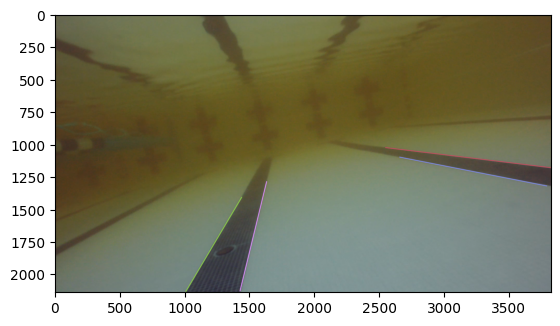

In [505]:
def merge_lines(lines, slope_thresh, x_int_thresh, distance_thresh):

    merged = []
    used = set()
    slopes, x_intercepts = get_slopes_intercepts(lines)

    def line_distance(p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))

    for i in range(len(lines)):
        if i in used:
            continue
        x1a, y1a, x2a, y2a = lines[i][0]
        slope_a = slopes[i]
        xint_a = x_intercepts[i]
        endpoints = [(x1a, y1a), (x2a, y2a)]

        for j in range(i + 1, len(lines)):
            if j in used:
                continue
            slope_b = slopes[j]
            xint_b = x_intercepts[j]
            x1b, y1b, x2b, y2b = lines[j][0]

            # Criteria to merge: similar slope & close in x-intercept or endpoint
            if abs(slope_a - slope_b) < slope_thresh:
                xint_close = abs(xint_a - xint_b) < x_int_thresh
                endpt_close = (
                    line_distance((x1a, y1a), (x1b, y1b)) < distance_thresh or
                    line_distance((x1a, y1a), (x2b, y2b)) < distance_thresh or
                    line_distance((x2a, y2a), (x1b, y1b)) < distance_thresh or
                    line_distance((x2a, y2a), (x2b, y2b)) < distance_thresh
                )

                if xint_close or endpt_close:
                    endpoints.extend([(x1b, y1b), (x2b, y2b)])
                    used.add(j)

        # Create a line from furthest two endpoints
        pts = np.array(endpoints)
        dists = np.sum((pts[:, None, :] - pts[None, :, :]) ** 2, axis=-1)
        i1, i2 = np.unravel_index(np.argmax(dists), dists.shape)
        merged.append(np.array([[pts[i1][0], pts[i1][1], pts[i2][0], pts[i2][1]]], dtype=np.int32))
        used.add(i)

    return merged

merged_lines_list = merge_lines(line_list, 0.05, 50, 50)
plt.imshow(draw_lines(image_file, merged_lines_list))
print(merged_lines_list)

In [506]:
def detect_lanes(lines, max_slope_diff, min_x_intercept_diff):
    # Step 1: Get slopes and x-intercepts
    slopes, x_intercepts = get_slopes_intercepts(lines)
    
    lanes = []
    n = len(lines)

    # Step 2: Check all unique line pairs
    for i in range(n):
        for j in range(i + 1, n):
            slope1, slope2 = slopes[i], slopes[j]
            x1, x2 = x_intercepts[i], x_intercepts[j]

            # Skip if any slope is inf (vertical line) or intercept is NaN
            if abs(slope1) == float('inf') or abs(slope2) == float('inf'):
                continue
            if x1 is None or x2 is None:
                continue

            # Step 3: Apply criteria for a lane
            if abs(slope1 - slope2) < max_slope_diff and abs(x1 - x2) > min_x_intercept_diff:
                lanes.append([lines[i], lines[j]])

    return lanes

lanes_list = detect_lanes(merged_lines_list, 1000, 1)
print(lanes_list)
print(len(lanes_list))

[[array([[2651, 1100, 3784, 1322]], dtype=int32), array([[2543, 1027, 3819, 1182]], dtype=int32)], [array([[2651, 1100, 3784, 1322]], dtype=int32), array([[1436, 1409, 1006, 2134]], dtype=int32)], [array([[2651, 1100, 3784, 1322]], dtype=int32), array([[1423, 2130, 1628, 1288]], dtype=int32)], [array([[2543, 1027, 3819, 1182]], dtype=int32), array([[1436, 1409, 1006, 2134]], dtype=int32)], [array([[2543, 1027, 3819, 1182]], dtype=int32), array([[1423, 2130, 1628, 1288]], dtype=int32)], [array([[1436, 1409, 1006, 2134]], dtype=int32), array([[1423, 2130, 1628, 1288]], dtype=int32)]]
6


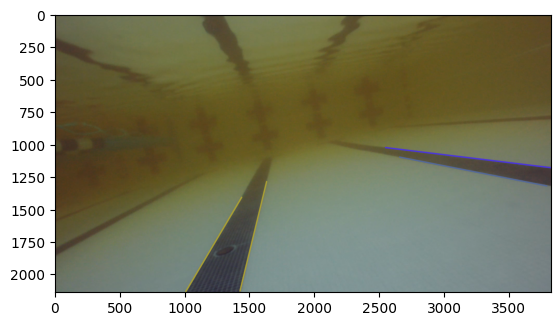

In [507]:

def draw_lanes(img_path, lanes, thickness=10):
    img = cv2.imread(img_path)

    for lane in lanes:
        # Generate a random color for each lane
        color = (
            random.randint(50, 255),  # Red
            random.randint(50, 255),  # Green
            random.randint(50, 255)   # Blue
        )

        for line in lane:
            x1, y1, x2, y2 = line[0]
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    return img


plt.imshow(draw_lanes(image_file, lanes_list))